In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from spline import *
from utils import read_pgm, read_eye_annotations, read_patch, read_norm_img
from scipy.signal import convolve2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect patches

In [8]:
import os


n_patches = 1000

patches = np.zeros((n_patches , 101, 101))

for i in range(n_patches):
    patch = read_patch(i, loc='left')

    patches[i] = patch

# Average model (A) TEST

## Fit the model

(1.734193262751288e-06, 0.00012247211628040207)

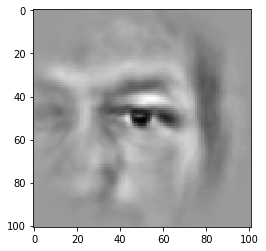

In [9]:
from models.averager import Averager
avg = Averager()
avg.train(patches, n_order=16)

# Display template
plt.imshow(avg.template, cmap='gray')
np.mean(avg.template), np.std(avg.template)

## Collect image and test

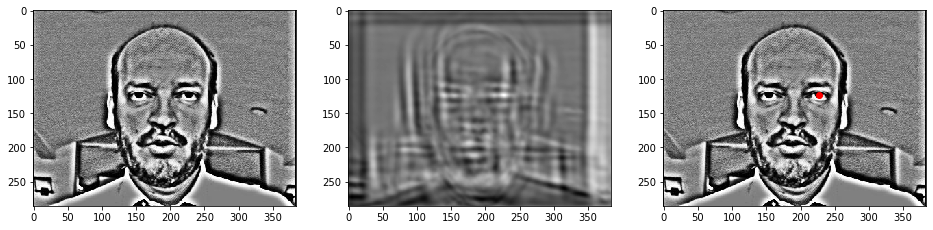

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
image = read_norm_img(17)



conv, (x, y) = avg.predict_im(image, ax3)

ax1.imshow(image, cmap='gray')
ax2.imshow(conv, cmap='gray')


In [11]:
Nx = Ny = 101  # Size of training samples
Nk = 51  # Size of the patches (x-direction)
Nl = 51  # Size of the patches (y-direction)
spline_deg = 3  # Degree of the B-spline used

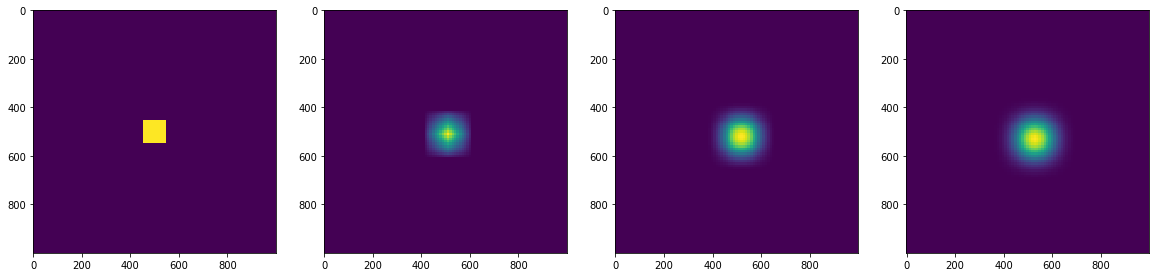

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 35))


Nx = Ny = 101
Nk = Nl = 51

sk = Nx / Nk
sl = Ny / Nk


x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)

B2d = make_2D_spline_deg_n(0, sk=sk, sl=sl)
ax1.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(1, sk=sk, sl=sl)
ax2.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(2, sk=sk, sl=sl)
ax3.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(3, sk=sk, sl=sl)
ax4.imshow(B2d(x, y))


In [252]:
import numpy as np
from scipy.signal import convolve2d


class LinRegR2(object):

    def __init__(self):
        """
        """
        self.S_matrix = None
        self.template = None
        self.pupil_location = None


    def __make_s_vector(self, Nx, Ny, Nk, Nl, train_patches, spline_deg=2):
        """
        Create the S matrix

        Inputs:
        -------

        Nx (int): The size of reference image x-axis
        Ny (int): The size of reference image y-axis
        Nk (int): The number of splines x-axis
        Nl (int): The number of splines y-axis
        train_patches (array): Array of shape (num_patch, patch_size) with the training samples
        spline_deg (int): The spline degree to use 
        """

        sk = Nx / Nk
        sl = Ny / Nl

        num_patch = train_patches.shape[0]

        self.S_matrix = np.zeros((num_patch, Nk * Nl))

        # Define splines
        x = np.array(range(-int( 5 * sk /2) + 1, int( 5 * sk /2) + 1 )) / sk
        y = np.array(range(-int( 5 * sl /2) + 1, int( 5 * sl /2) + 1 )) / sl

        # Define 2D splines
        B = discrete_spline_2D(x, y, spline_deg)

        # Generate k, l coordinates 
        k = np.array(range(0, 51))
        l = np.array(range(0, 51))

        # Convert them to x, y coordinate for mapping
        x, y = spline_kl_to_xy(k, l, sk, sl)
        
        
        for i in range(num_patch):

            if i % 100 == 0:
                print('Patch {}'.format(i))

            S_matrix_i = convolve2d(train_patches[i], B,  mode='same')

            # Get the corresponding points in(x, y) grid and flatten
            self.S_matrix[i] = S_matrix_i[x, :][:, y].flatten()


    def train(self, Nx, Ny, Nk, Nl, train_patches, labels, spline_deg=2):

        self.__make_s_vector(Nx, Ny, Nk, Nl, train_patches, spline_deg)

        A = np.dot(self.S_matrix.T, self.S_matrix)
        b = np.dot(self.S_matrix.T, labels)

        c = np.linalg.lstsq(A, b)

        self.spline_coef = c[0]


        

    def make_temp_from_spline(self, spline_deg=3, Nk=51, Nl=51, sk=1, sl=1):

        
        def template(x, y):

            s = 0

            k = np.array(range(- int(Nk / 2), int(Nk /2) +1))
            l = np.array(range(- int(Nk / 2), int(Nk /2) +1))

            x, y = xy_to_kl(x, y)


            B = discrete_spline_2D(x - k * sk, y - l * sl, spline_deg).reshape(1, Nk * Nl)


            return np.dot(B[np.newaxis, :], self.spline_coef)

        return template






        

In [253]:
np.array(range(- int(Nk / 2), int(Nk /2) +1)).shape

(51,)

In [254]:
n_patches = 1000

pos_patches = np.zeros((n_patches , 101, 101))
pos_labels = np.ones((n_patches , 1))

neg_patches = np.zeros((n_patches , 101, 101))
neg_labels = np.zeros((n_patches , 1))

for i in range(n_patches):
    pos_patch = read_patch(i, loc='left', pos_neg="positive")
    neg_patch = read_patch(i, loc='left', pos_neg="negative")
    
    pos_patches[i] = pos_patch
    neg_patches[i] = neg_patch

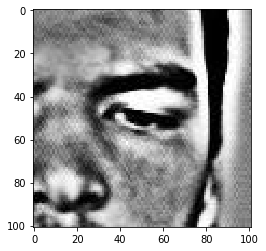

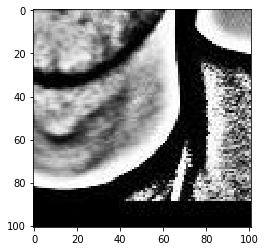

In [255]:
plt.imshow(pos_patches[0], cmap='gray')
plt.show()

plt.imshow(neg_patches[0], cmap='gray')
plt.show()

In [256]:
train_patches = np.vstack((pos_patches, neg_patches))
train_labels =  np.vstack((pos_labels, neg_labels))

In [257]:

lin = LinRegR2()
lin.train(Nx, Ny, Nk, Nl, train_patches=train_patches, labels=train_labels, spline_deg=3)

Patch 0
Patch 100
Patch 200
Patch 300
Patch 400
Patch 500
Patch 600
Patch 700
Patch 800
Patch 900
Patch 1000
Patch 1100
Patch 1200
Patch 1300
Patch 1400
Patch 1500
Patch 1600
Patch 1700
Patch 1800
Patch 1900


In [127]:
(dim_y, dim_x) = Nx, Ny
X = np.array(range(2 * dim_x + 1, 4 * dim_x + 1))
Y = np.array(range(2 * dim_y + 1, 4 *  dim_y + 1))

temp = np.array([[lin.make_temp_from_spline()(x,y) for x in X] for y in Y])


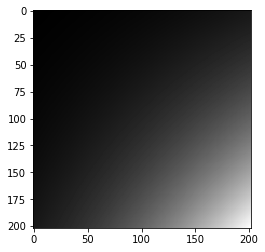

In [130]:
plt.imshow(temp.reshape(101, 101), cmap='gray')

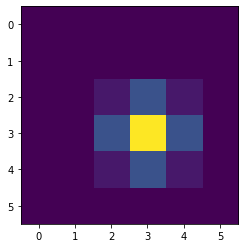

In [50]:
k = np.array(range(- int((2 * spline_deg + 1) / 2), int((2 * spline_deg + 1) / 2)))
l = np.array(range(- int((2 * spline_deg + 1) / 2), int((2 * spline_deg + 1) / 2)))

B = discrete_spline_2D(k, l, spline_deg)

plt.imshow(B)

In [247]:
from spline import xy_to_kl

def template(x, y):

            s = 0

            k = np.array(range(- int(Nk / 2), int(Nk /2) +1))
            l = np.array(range(- int(Nk / 2), int(Nk /2) +1))

            k = np.array(range(0, Nk))
            l = np.array(range(0, Nk))

            #x, y = xy_to_kl(x, y, sk, sl)


            B = discrete_spline_2D(x - k * sk, y - l * sl, spline_deg).reshape(Nk * Nl)


            return np.dot(B[np.newaxis, :], lin.spline_coef)

In [248]:
from spline import xy_to_kl

def template_bis(x, y):

    s = 0

    k = np.array(range(-int( 5 * sk /2) + 1, int( 5 * sk /2) + 1 )) / sk
    l = np.array(range(-int( 5 * sl /2) + 1, int( 5 * sl /2) + 1 )) / sl    

    x, y = xy_to_kl(x, y, sk, sl)



    B = discrete_spline_2D(k, l, spline_deg)

    c = lin.spline_coef.reshape(Nk, Nl)

    conv = convolve2d(c, B,  mode='same')



    return conv

In [249]:
template_bis(0, 1)

array([[-4.84025037e-06, -8.58844579e-06, -7.23257666e-06, ...,
         1.09382654e-06,  9.47242560e-07,  5.38555497e-07],
       [-3.37330931e-06, -5.88134244e-06, -4.69863860e-06, ...,
         1.76774946e-06,  1.62399809e-06,  1.01978283e-06],
       [-9.53654871e-07, -1.49484977e-06, -7.28158522e-07, ...,
         2.05138705e-06,  2.02583319e-06,  1.37608058e-06],
       ...,
       [ 1.08652658e-06,  1.50888785e-06,  1.66127754e-06, ...,
         1.01989122e-06,  8.40630568e-07,  5.66253261e-07],
       [ 7.25981627e-07,  9.85510729e-07,  1.11252423e-06, ...,
         7.65121431e-07,  5.62119704e-07,  3.23966299e-07],
       [ 2.30664206e-07,  2.98753511e-07,  4.22274311e-07, ...,
         4.53618322e-07,  2.80383100e-07,  1.47774375e-07]])

In [250]:
(dim_y, dim_x) = Nx, Ny
X = np.array(range(- int(dim_x / 2), int(dim_x / 2 ) + 1))
Y = np.array(range(- int(dim_y / 2), int(dim_y / 2 ) + 1))

X = np.array(range(0, dim_x))
Y = np.array(range(0, dim_y))

temp = np.array([[template(x,y) for x in X] for y in Y])

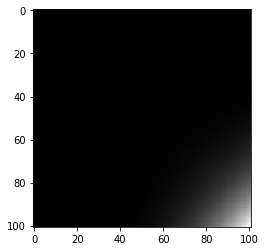

In [251]:
plt.imshow(temp.reshape(101, 101), cmap='gray')

In [227]:
np.max(temp), np.min(temp)

(3.7484114286628074e-06, -8.588445789860697e-06)

In [96]:
from scipy.interpolate import bisplrep
from scipy.interpolate import bisplev

In [224]:
x, y = np.mgrid[-1:1:101j, -1:1:101j]

#x, y = np.meshgrid(x, y)
tck = bisplrep(x, y, temp, s=0)

x, y = np.mgrid[-1:1:202j, -1:1:202j]

#x_new, y_new = np.meshgrid(x_new, y_new)

inter = bisplev(x_new[:,0], y_new[0,:], tck)

In [226]:
temp

array([[5.40489176e-07, 5.40489176e-07, 5.40489176e-07, ...,
        2.44387494e-06, 2.57480334e-06, 2.57480334e-06],
       [5.40489176e-07, 5.40489176e-07, 5.40489176e-07, ...,
        2.44387494e-06, 2.57480334e-06, 2.57480334e-06],
       [5.40489176e-07, 5.40489176e-07, 5.40489176e-07, ...,
        2.44387494e-06, 2.57480334e-06, 2.57480334e-06],
       ...,
       [7.45198427e-07, 7.45198427e-07, 7.45198427e-07, ...,
        2.09143632e-06, 2.16869283e-06, 2.16869283e-06],
       [6.36300153e-07, 6.36300153e-07, 6.36300153e-07, ...,
        2.11875010e-06, 2.16191977e-06, 2.16191977e-06],
       [6.36300153e-07, 6.36300153e-07, 6.36300153e-07, ...,
        2.11875010e-06, 2.16191977e-06, 2.16191977e-06]])

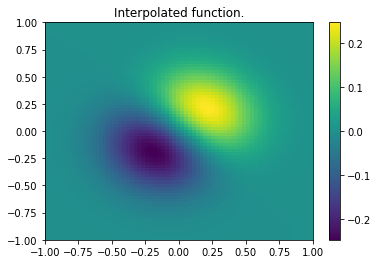

In [221]:
x, y = np.mgrid[-1:1:20j, -1:1:20j]
z = (x+y) * np.exp(-6.0*(x*x+y*y))

xnew, ynew = np.mgrid[-1:1:70j, -1:1:70j]
tck = bisplrep(x, y, z, s=0)
znew = bisplev(xnew[:,0], ynew[0,:], tck)

plt.figure()
plt.pcolor(xnew, ynew, znew)
plt.colorbar()
plt.title("Interpolated function.")
plt.show()

In [223]:
x.shape

(20, 20)